In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## 模型结构定义

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 加载cifar10数据集

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=False, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


## 创建模型对象和优化器
### 1. 对比的优化器包括5个，分别为'SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad'
### 2. 同时创建5个模型对象
### 3. 采用交叉熵损失
### 4. 所有优化器均设置相同的起始学习率，lr均设置为0.001

In [8]:
# loss func
criterion = nn.CrossEntropyLoss()

# models and optims
optim_name = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad']
model_list = []
for i in range(len(optim_name)):
    model_list.append(Net())

optim_list = []
# SGD
optim_SGD = optim.SGD(model_list[0].parameters(), lr=0.001)
optim_list.append(optim_SGD)
# Adam
optim_Adam = optim.Adam(model_list[1].parameters(), lr=0.001)
optim_list.append(optim_Adam)
# RMSProp
optim_RMSprop = optim.RMSprop(model_list[2].parameters(), lr=0.001)
optim_list.append(optim_RMSprop)
# Adadelta
optim_Adadelta = optim.Adadelta(model_list[3].parameters(), lr=0.001)
optim_list.append(optim_Adadelta)
# Adagrad
optim_Adagrad = optim.Adagrad(model_list[4].parameters(), lr=0.001) 
optim_list.append(optim_Adagrad)


## 定义训练epoch数， 5个模型同时训练，每个epoch结束打印loss

In [9]:
epoch_num = 20
loss_matrix = np.zeros((len(optim_name), epoch_num))

In [10]:
print('Start Training')
for epoch in range(epoch_num):  # loop over the dataset multiple times
    iter_num = 0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        iter_num = i
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

#         # zero the parameter gradients
#         optimizer.zero_grad()
#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

        # 同步训练所有模型
        for j in range(len(optim_name)):
            optim_list[j].zero_grad()
            outputs = model_list[j](inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optim_list[j].step()
            loss_matrix[j, epoch] += loss.item()
                   
        #print('[epoch:%d, iter:%5d] loss: %.3f optim: %s' %
        #          (epoch + 1, i + 1, loss.item(), optim_name[j]))
    loss_matrix[:, epoch] /= iter_num
    print("[epoch:{}]".format(epoch+1))
    for idx in range(len(optim_name)):
        print("     loss:{}, optim:{}".format(loss_matrix[idx, epoch], optim_name[idx]))
   
print('Finished Training')

Start Training
[epoch:1]
     loss:2.3031483218550837, optim:SGD
     loss:1.5599472677089494, optim:Adam
     loss:1.5493894013911296, optim:RMSprop
     loss:2.304090323124591, optim:Adadelta
     loss:1.975571571483197, optim:Adagrad
[epoch:2]
     loss:2.296751737518286, optim:SGD
     loss:1.2733355504335424, optim:Adam
     loss:1.2719583066034867, optim:RMSprop
     loss:2.298562913255411, optim:Adadelta
     loss:1.87087541715589, optim:Adagrad
[epoch:3]
     loss:2.2690851154919622, optim:SGD
     loss:1.1560735161894415, optim:Adam
     loss:1.1327467944172525, optim:RMSprop
     loss:2.2867451795542593, optim:Adadelta
     loss:1.8258693418185323, optim:Adagrad
[epoch:4]
     loss:2.1917156023802127, optim:SGD
     loss:1.076387825909711, optim:Adam
     loss:1.0338856950688453, optim:RMSprop
     loss:2.2583659968974494, optim:Adadelta
     loss:1.7896075998164627, optim:Adagrad
[epoch:5]
     loss:2.0854890232049548, optim:SGD
     loss:1.0135511721218442, optim:Adam
     

## 模型保存

In [11]:
for idx in range(len(optim_name)):
    PATH = './cifar_net_{}.pth'.format(optim_name[idx])
    torch.save(model_list[idx].state_dict(), PATH)

## 画loss图，对比5个模型训练过程的loss变化情况
## 结论： 
### 1. 可以看出，效果最好的是Adam和RMSprop，且loss下降最快，变化趋势很接近
### 2. SGD在该训练方式下loss下降缓慢，效果最差

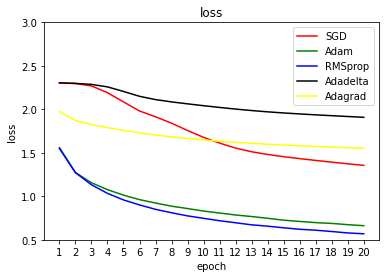

In [32]:
import matplotlib.pyplot as plt

colors = ['red', 'green', 'blue', 'black', 'yellow']
x = np.array(range(20)) + 1
plt.figure()
plt.title("loss")
for idx in range(len(optim_name)):
    plt.plot(x, loss_matrix[idx, :], color = colors[idx], label=optim_name[idx])
plt.legend(loc=0)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xticks(x)
plt.ylim(ymin=0.5, ymax=3)
plt.savefig('loss.jpg')
plt.show()


## 整体对比5个模型的准确率情况

In [23]:
#在整个数据集上测试
correct = np.zeros(5)
total = np.zeros(5)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        for idx in range(len(optim_name)):
            outputs = model_list[idx](images)
            _, predicted = torch.max(outputs.data, 1)
            total[idx] += labels.size(0)
            correct[idx] += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images:')
acc = 100 * correct / total
for idx in range(len(optim_name)):
    print("Acc: {} %, optim: {}".format(acc[idx], optim_name[idx]))

Accuracy of the network on the 10000 test images:
Acc: 51.28 %, optim: SGD
Acc: 58.16 %, optim: Adam
Acc: 61.05 %, optim: RMSprop
Acc: 31.85 %, optim: Adadelta
Acc: 44.76 %, optim: Adagrad


## 计算5个模型各个类别的准确率

In [24]:
class_correct = np.zeros((5,10))      # list(0. for i in range(10))
class_total = np.zeros((5,10))        # list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        for idx in range(len(optim_name)):
            outputs = model_list[idx](images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[idx, label] += c[i].item()
                class_total[idx, label] += 1

for idx in range(5):
    print("optim:{}".format(optim_name[idx]))
    for i in range(10):
        print('    Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[idx, i] / class_total[idx, i]))

optim:SGD
    Accuracy of plane : 48 %
    Accuracy of   car : 76 %
    Accuracy of  bird : 27 %
    Accuracy of   cat : 27 %
    Accuracy of  deer : 38 %
    Accuracy of   dog : 42 %
    Accuracy of  frog : 64 %
    Accuracy of horse : 72 %
    Accuracy of  ship : 63 %
    Accuracy of truck : 56 %
optim:Adam
    Accuracy of plane : 63 %
    Accuracy of   car : 76 %
    Accuracy of  bird : 38 %
    Accuracy of   cat : 44 %
    Accuracy of  deer : 43 %
    Accuracy of   dog : 49 %
    Accuracy of  frog : 64 %
    Accuracy of horse : 62 %
    Accuracy of  ship : 75 %
    Accuracy of truck : 58 %
optim:RMSprop
    Accuracy of plane : 66 %
    Accuracy of   car : 75 %
    Accuracy of  bird : 41 %
    Accuracy of   cat : 44 %
    Accuracy of  deer : 50 %
    Accuracy of   dog : 48 %
    Accuracy of  frog : 73 %
    Accuracy of horse : 67 %
    Accuracy of  ship : 72 %
    Accuracy of truck : 73 %
optim:Adadelta
    Accuracy of plane : 53 %
    Accuracy of   car : 35 %
    Accuracy of  bird 

## 统计5个模型中准确率最高和最低的类别

In [30]:
acc_matrix = class_correct / class_total * 100
for idx in range(5):
    print("optim:{}".format(optim_name[idx]))
    print("    准确率最高的类别: {}, 准确率:{:.0f} %".format(classes[np.argmax(acc_matrix[idx,:])], np.max(acc_matrix[idx,:])))
    print("    准确率最低的类别: {}, 准确率:{:.0f} %".format(classes[np.argmin(acc_matrix[idx,:])], np.min(acc_matrix[idx,:])))

optim:SGD
    准确率最高的类别: car, 准确率:77 %
    准确率最低的类别: bird, 准确率:27 %
optim:Adam
    准确率最高的类别: car, 准确率:77 %
    准确率最低的类别: bird, 准确率:39 %
optim:RMSprop
    准确率最高的类别: car, 准确率:76 %
    准确率最低的类别: bird, 准确率:41 %
optim:Adadelta
    准确率最高的类别: frog, 准确率:60 %
    准确率最低的类别: bird, 准确率:2 %
optim:Adagrad
    准确率最高的类别: frog, 准确率:63 %
    准确率最低的类别: bird, 准确率:22 %
